# Big Data Project

### **Participants:**  Jialin Li(Cullen)
### **Date:** 05-10-2021
# **Steps:**
1. **Download Dataset**
2. **Install the Scala Kernel And Set Up the Envoirment**
3. **Install dependentcies**
4. **Describe Data**
5. **Data Preparation**
6. **Algorithm Implementation**
### **Research Hypothesis:** 
* From my perception, customer review comments from Amazon have a high correlation with star ranking from customers.  With this perception, I made a few training model to predict the star rankning( which as the satifaction to the product) for the customers.
### **Research Questions:** 
1. Does the frequency of words from comments affect the percentage of satisfaction?
2. Is there a correlation between the percentage of the frequency with every word in comments?
---
### **Data Source:**

1. **Amazon Review Data (2018)** : http://deepyeti.ucsd.edu/jianmo/amazon/
2. **Affective Text** : http://web.eecs.umich.edu/~mihalcea/affectivetext

# Step 1: Download Dataset

In [4]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
!gzip -d Video_Games_5.json.gz
!wget http://web.eecs.umich.edu/~mihalcea/affectivetext/data/WordNetAffectEmotionLists.tar.gz
!tar -xf WordNetAffectEmotionLists.tar.gz

--2021-05-09 00:02:45--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz’

Video_Games_5.json. 100%[===================>] 146.91M  45.9MB/s    in 3.2s    

2021-05-09 00:02:48 (45.9 MB/s) - ‘Video_Games_5.json.gz’ saved [154050105/154050105]

--2021-05-09 00:02:53--  http://web.eecs.umich.edu/~mihalcea/affectivetext/data/WordNetAffectEmotionLists.tar.gz
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8287 (8.1K) [application/x-gzip]
Saving to: ‘WordNetAffectEmotionLists.tar.gz’

WordNetAffectEmotio 100%[=============

# **Step 2:Install the Scala Kernel And Set Up the Envoirment**
If you get a "scala" kernel not recognized warning when loading up the notebook for the first time, start by running the two cells below. Once you are done **reload the page** to load the notebook in the installed Scala kernel.

In [5]:
!curl -Lo coursier https://git.io/coursier-cli && chmod +x coursier
!./coursier launch --fork almond:0.10.9 --scala 2.12 -- --install &> /dev/null 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   135  100   135    0     0    314      0 --:--:-- --:--:-- --:--:--   314
100 42577  100 42577    0     0  74565      0 --:--:-- --:--:-- --:--:-- 74565


In [1]:
println("(Testing)Hello, world!")

(Testing)Hello, world!


# **Step 3: Install dependentcies**

In [1]:
import $ivy.`org.slf4j:slf4j-api:2.0.0-alpha1`
import $ivy.`org.slf4j:slf4j-log4j12:2.0.0-alpha1`
import $ivy.`org.apache.spark::spark-core:3.1.1`
import $ivy.`org.apache.spark::spark-sql:3.1.1`
import $ivy.`org.apache.spark::spark-mllib:3.1.1`
// import $ivy.`com.nvidia::rapids-4-spark:0.4.1`
// import $ivy.`ai.rapids:cudf:0.18.1`
import $ivy.`log4j:log4j:1.2.17`
import $ivy.`org.jsoup:jsoup:1.13.1`
import $ivy.`org.plotly-scala::plotly-almond:0.8.2`
import coursierapi._
import sys.process._
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)

import $ivy.$                                 

import $ivy.$                                     

import $ivy.$                                   

import $ivy.$                                  

import $ivy.$                                    
// import $ivy.`com.nvidia::rapids-4-spark:0.4.1`
// import $ivy.`ai.rapids:cudf:0.18.1`

import $ivy.$                   

import $ivy.$                       

import $ivy.$                                      

import coursierapi._

import sys.process._

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

import org.apache.log4j.{Level, Logger}


In [2]:
import org.apache.spark.sql._

implicit class RichDF(val df: DataFrame) {
  def showHTML(limit:Int = 20, truncate: Int = 20) = {
    import xml.Utility.escape
    val data = df.take(limit)
    val header = df.schema.fieldNames.toSeq
    val rows: Seq[Seq[String]] = data.map(_.toSeq.map(cell =>
        (cell match {
          case null => "null"
          case binary: Array[Byte] => binary.map("%02X".format(_)).mkString("[", " ", "]")
          case array: Array[_] => array.mkString("[", ", ", "]")
          case seq: Seq[_] => seq.mkString("[", ", ", "]")
          case _ => cell.toString
        }).take(truncate)
      ).map(p=> if(p.length >= truncate) p + "..." else p)
    )

    publish.html(s"""
      <table class="table dataframe" border="1">
        <tr>
        ${header.map(h => s"<th>${escape(h)}</th>").mkString}
        </tr>
        ${rows.map { row =>
          s"<tr>${row.map { c => s"<td>${escape(c)}</td>" }.mkString}</tr>"
        }.mkString
        }
      </table>""")
  }
}

import org.apache.spark.sql._


defined class RichDF

In [3]:
import org.apache.spark.SparkConf
import org.apache.spark.SparkContext

val spark = NotebookSparkSession.builder()
    .appName("Product Satisfaction")
//     .config("spark.driver.resource.gpu.amount", "1")
    .config("spark.executor.memory","32g")
//     .config("spark.eventLog.enabled", "true")
    .config("spark.driver.cores", "4")
    .master("local[*]")
    .getOrCreate()
val sc = spark.sparkContext
val sqlContext= spark.sqlContext
// val conf = new SparkConf()
//             .set("spark.plugins", "com.nvidia.spark.SQLPlugin")
//             .set("spark.executor.resource.gpu.discoveryScript", "getGpusResources.sh")
//             .set("spark.rapids.sql.incompatibleOps.enabled", "true")
//             .set("spark.executor.resource.gpu.amount", "1")
//             .set("hadoop.home.dir","D:\\hadoop-3.2.2")
//             .set("spark.ui.enabled","true")
//             .setMaster("local[*]")
//             .setAppName("Product Satisfaction")


// val sc = new SparkContext(conf)
// val sqlContext= new SQLContext(sc)
// val spark=sqlContext.sparkSession

import spark.implicits._

//import org.jsoup.Jsoup
//kernel.publish.html(Jsoup.connect("http://8a1f1a0b9848:4040/").get().outerHtml())

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import org.apache.spark.SparkConf

import org.apache.spark.SparkContext


spark: SparkSession = org.apache.spark.sql.SparkSession@6aaade40
sc: SparkContext = org.apache.spark.SparkContext@63c5e9eb
sqlContext: SQLContext = org.apache.spark.sql.SQLContext@11a7d1ac
import spark.implicits._

//import org.jsoup.Jsoup
//kernel.publish.html(Jsoup.connect("http://8a1f1a0b9848:4040/").get().outerHtml())

# **Step 4: Describe Data**


In [4]:
val amazonComment = spark.read.json("res\\Video_Games_5.json")
amazonComment.printSchema()
amazonComment.showHTML()
amazonComment.count()


json at cmd3.sc:1

8 / 8

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color Name:: string (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Configuration:: string (nullable = true)
 |    |-- Content:: string (nullable = true)
 |    |-- Denomination:: string (nullable = true)
 |    |-- Edition:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Length:: string (nullable = true)
 |    |-- Offer Type:: string (nullable = true)
 |    |-- Package Quantity:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Pattern:: string (nullable = true)
 | 

take at cmd1.sc:6

1 / 1

asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0700026657,null,5.0,This game is a bit h...,"10 17, 2015",A1HP7NVNPFMA4N,Ambrosia075,null,but when you do it's...,1445040000,true,null
0700026657,null,4.0,I played it a while ...,"07 27, 2015",A1JGAP0185YJI6,travis,null,But in spite of that...,1437955200,false,null
0700026657,null,3.0,ok game.,"02 23, 2015",A1YJWEXHQBWK2B,Vincent G. Mezera,null,Three Stars,1424649600,true,null
0700026657,null,2.0,found the game a bit...,"02 20, 2015",A2204E1TH211HT,Grandma KR,null,Two Stars,1424390400,true,null
0700026657,null,5.0,"great game, I love i...","12 25, 2014",A2RF5B5H74JLPE,jon,null,love this game,1419465600,true,null
0700026657,null,4.0,i liked a lot some t...,"11 13, 2014",A11V6ZJ2FVQY1D,IBRAHIM ALBADI,null,Anno 2070,1415836800,true,null
0700026657,null,1.0,"I'm an avid gamer, b...","08 2, 2014",A1KXJ1ELZIU05C,Creation27,null,Avoid This Game - Fi...,1406937600,false,null
0700026657,null,5.0,I bought this game t...,"03 3, 2014",A1WK5I4874S3O2,WhiteSkull,null,A very good game bal...,1393804800,true,null
0700026657,null,5.0,I have played the ol...,"02 21, 2014",AV969NA4CBP10,Travis B. Moore,null,Anno 2070 more like ...,1392940800,true,null
0700026657,null,4.0,I liked it and had f...,"06 27, 2013",A1EO9BFUHTGWKZ,johnnyz3,null,Pretty fun,1372291200,true,null


count at cmd3.sc:4

8 / 8

count at cmd3.sc:4

1 / 1

amazonComment: DataFrame = [asin: string, image: array<string> ... 10 more fields]
res3_3: Long = 497577L

collect at cmd4.sc:2

8 / 8

collect at cmd4.sc:2

200 / 200

collect at cmd4.sc:3

8 / 8

collect at cmd4.sc:3

200 / 200

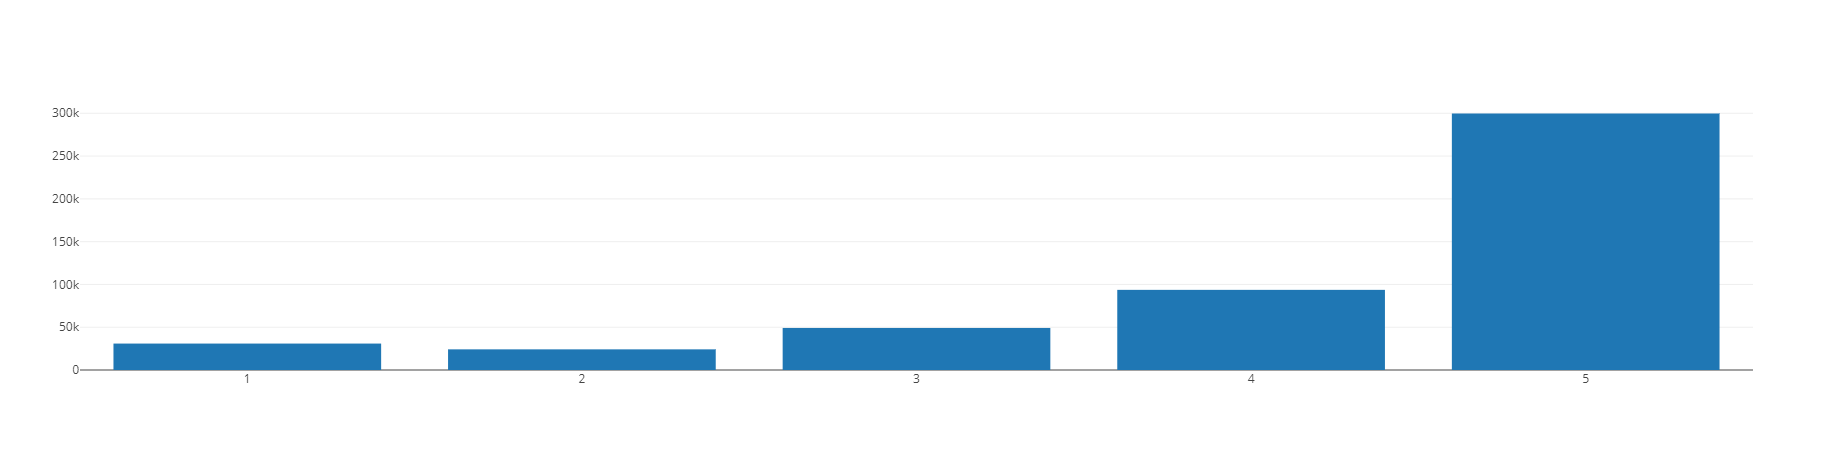

hist: DataFrame = [overall: double, count: bigint]
name: Seq[Double] = WrappedArray(1.0, 4.0, 3.0, 2.0, 5.0)
value: Seq[Long] = WrappedArray(30883L, 93654L, 49146L, 24135L, 299759L)
data: Seq[Bar] = List(
  Bar(
    Doubles(WrappedArray(1.0, 4.0, 3.0, 2.0, 5.0)),
    Doubles(ArrayBuffer(30883.0, 93654.0, 49146.0, 24135.0, 299759.0)),
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None
  )
)
res4_4: String = "plot-c0e8ab74-6f8a-4111-be20-deba236f6aff"

In [5]:
val hist = amazonComment.groupBy("overall").count()
val name = hist.select("overall").collect().map(_.getDouble(0)).toSeq
val value = hist.select("count").collect().map(_.getLong(0)).toSeq
val data = Seq(Bar(name,value))
plot(data)

In [6]:
import java.io.File
val files = new File("res\\WordNetAffectEmotionLists").listFiles.map(_.getName).filter(_!="README")
val emotionLables = (files.map(f => sc.textFile("WordNetAffectEmotionLists/"+ f ).map(_.split(' ').drop(1)).flatMap(l=>l).map(f.dropRight(4) -> _)).fold(sc.emptyRDD[(String, String)])(_ ++ _)).toDF("emotion","word")
emotionLables.showHTML()

take at cmd1.sc:6

1 / 1

emotion,word
anger,wrath
anger,umbrage
anger,offense
anger,pique
anger,temper
anger,irritation
anger,lividity
anger,irascibility
anger,short_temper
anger,spleen


import java.io.File

files: Array[String] = Array(
  "anger.txt",
  "disgust.txt",
  "fear.txt",
  "joy.txt",
  "sadness.txt",
  "surprise.txt"
)
emotionLables: DataFrame = [emotion: string, word: string]

collect at cmd6.sc:3

12 / 12

collect at cmd6.sc:3

200 / 200

collect at cmd6.sc:4

12 / 12

collect at cmd6.sc:4

200 / 200

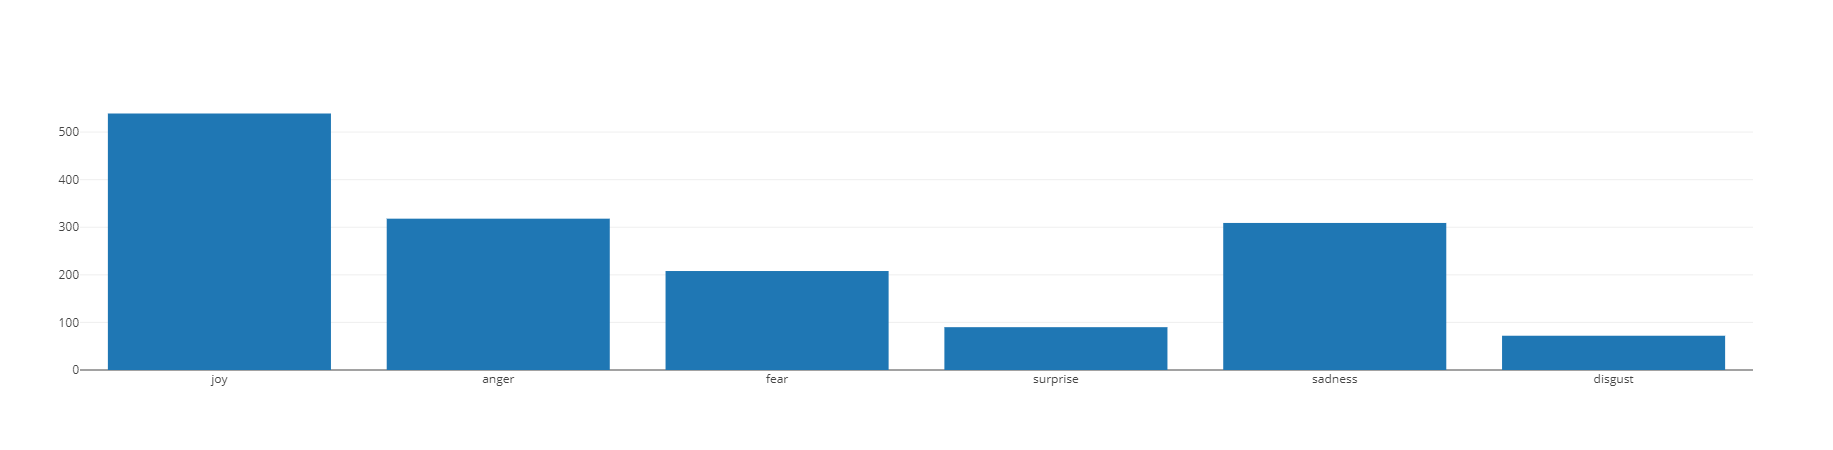

import plotly.element._

hist: DataFrame = [emotion: string, count: bigint]
name: Seq[String] = WrappedArray(
  "joy",
  "anger",
  "fear",
  "surprise",
  "sadness",
  "disgust"
)
value: Seq[Long] = WrappedArray(539L, 318L, 208L, 90L, 309L, 72L)
data: Seq[Bar] = List(
  Bar(
    Strings(
      WrappedArray("joy", "anger", "fear", "surprise", "sadness", "disgust")
    ),
    Doubles(ArrayBuffer(539.0, 318.0, 208.0, 90.0, 309.0, 72.0)),
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None
  )
)
res6_5: String = "plot-0f8cb3dc-8f06-4f26-b7da-b5c4d121a6a9"

In [7]:
import plotly.element._
val hist = emotionLables.groupBy("emotion").count()
val name = hist.select("emotion").collect().map(_.getString(0)).toSeq
val value = hist.select("count").collect().map(_.getLong(0)).toSeq
val data = Seq(Bar(name,value))
plot(data)

## **4.1 Transformate Data**

In [8]:
import org.apache.spark.sql.functions.concat
val transformatedDF = amazonComment.select(($"overall" / 5).as("satisfaction") ,concat($"reviewText",$"summary").as("sentence"))
transformatedDF.showHTML()
transformatedDF.count()
transformatedDF.describe("satisfaction", "sentence").showHTML()

take at cmd1.sc:6

1 / 1

satisfaction,sentence
1.0,This game is a bit h...
0.8,I played it a while ...
0.6,ok game.Three Stars
0.4,found the game a bit...
1.0,"great game, I love i..."
0.8,i liked a lot some t...
0.2,"I'm an avid gamer, b..."
1.0,I bought this game t...
1.0,I have played the ol...
0.8,I liked it and had f...


count at cmd7.sc:4

8 / 8

count at cmd7.sc:4

1 / 1

describe at cmd7.sc:5

8 / 8

describe at cmd7.sc:5

1 / 1

summary,satisfaction,sentence
count,497577,497316
mean,0.8440912662764146,null
stddev,0.23708488662747057,null
min,0.2,VidegameFive Stars
max,1.0,~~~EDIT 7-21-2017~~~...


import org.apache.spark.sql.functions.concat

transformatedDF: DataFrame = [satisfaction: double, sentence: string]
res7_3: Long = 497577L

# **Step 5: Data Preparation**

## 5.1 Null Value Check

In [9]:
val nullCheckedDF = transformatedDF.filter($"sentence".isNotNull)

nullCheckedDF: Dataset[Row] = [satisfaction: double, sentence: string]

### 5.3 Sentence Separation

In [10]:
import org.apache.spark.ml.feature.Tokenizer
val tokenizer = new Tokenizer().setInputCol("sentence").setOutputCol("words")
val wordsData = tokenizer.transform(nullCheckedDF.sample(0.5))
wordsData.showHTML()
wordsData.count()
wordsData.printSchema()


take at cmd1.sc:6

1 / 1

satisfaction,sentence,words
1.0,This game is a bit h...,"[this, game, is, a, ..."
0.8,i liked a lot some t...,"[i, liked, a, lot, s..."
0.2,"I'm an avid gamer, b...","[i'm, an, avid, game..."
1.0,I have played the ol...,"[i, have, played, th..."
0.8,4 Stars because they...,"[4, stars, because, ..."
1.0,Loved playing Dirt 2...,"[loved, playing, dir..."
1.0,I'm not quite finish...,"[i'm, not, quite, fi..."
1.0,lot of people don't ...,"[lot, of, people, do..."
1.0,i like bf games and ...,"[i, like, bf, games,..."
0.8,This installment int...,"[this, installment, ..."


count at cmd9.sc:5

8 / 8

count at cmd9.sc:5

1 / 1

root
 |-- satisfaction: double (nullable = true)
 |-- sentence: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



import org.apache.spark.ml.feature.Tokenizer

tokenizer: Tokenizer = tok_1138d9e68eaf
wordsData: DataFrame = [satisfaction: double, sentence: string ... 1 more field]
res9_4: Long = 249197L

In [30]:
import scala.collection.mutable.WrappedArray
val emotionLablesMap = emotionLables.flatMap(p => Map(p.getString(1)-> p.getString(0))).collect().toMap
val emotionExtraction = wordsData.map(_.getAs[WrappedArray[String]](2).map(p => emotionLablesMap.getOrElse(p,null)).filter(_ !=null))
emotionExtraction.show()

collect at cmd29.sc:2

12 / 12

show at cmd29.sc:4

1 / 1

+--------------------+
|               value|
+--------------------+
|          [surprise]|
|               [joy]|
|[joy, anger, surp...|
|[joy, surprise, s...|
|          [joy, joy]|
|     [joy, surprise]|
|[joy, joy, joy, j...|
|[joy, joy, surprise]|
|          [joy, joy]|
|          [joy, joy]|
|[joy, joy, joy, s...|
|               [joy]|
|                  []|
|               [joy]|
|     [joy, surprise]|
|                  []|
|[joy, joy, joy, s...|
|[sadness, anger, ...|
|     [joy, surprise]|
|[surprise, joy, s...|
+--------------------+
only showing top 20 rows



import scala.collection.mutable.WrappedArray

emotionLablesMap: Map[String, String] = Map(
  "terrible" -> "fear",
  "jolly_along" -> "joy",
  "rage" -> "anger",
  "desolate" -> "sadness",
  "exuberance" -> "joy",
  "scare" -> "fear",
  "avidness" -> "joy",
  "jubilancy" -> "joy",
  "trance" -> "joy",
  "unhappiness" -> "sadness",
  "enthralling" -> "joy",
  "timidly" -> "fear",
  "carefreeness" -> "joy",
  "astonishment" -> "surprise",
  "down" -> "sadness",
  "carefree" -> "joy",
  "unsure" -> "fear",
  "euphoria" -> "joy",
  "terrifically" -> "surprise",
  "choler" -> "anger",
  "covet" -> "anger",
  "cruelty" -> "fear",
  "foul" -> "disgust",
  "rue" -> "sadness",
  "screaming" -> "joy",
  "dumbfounded" -> "surprise",
  "diffidence" -> "fear",
  "frightful" -> "fear",
  "pathetic" -> "sadness",
  "gravel" -> "surprise",
  "thunderstruck" -> "surprise",
  "presentiment" -> "fear",
  "intimidation" -> "fear",
  "elan" -> "joy",
  "get_down" -> "sadness",
  "favourable" -> "joy",
  "t

In [31]:
val emotionExtractionHist = emotionExtraction.map(_.groupBy(l=>l).map(t =>(t._1-> t._2.size)).toSeq)
emotionExtractionHist.take(5)
emotionExtractionHist.show()

take at cmd30.sc:2

1 / 1

show at cmd30.sc:3

1 / 1

+--------------------+
|               value|
+--------------------+
|     [{surprise, 1}]|
|          [{joy, 1}]|
|[{surprise, 1}, {...|
|[{surprise, 2}, {...|
|          [{joy, 2}]|
|[{surprise, 1}, {...|
|          [{joy, 6}]|
|[{surprise, 1}, {...|
|          [{joy, 2}]|
|          [{joy, 2}]|
|[{surprise, 1}, {...|
|          [{joy, 1}]|
|                  []|
|          [{joy, 1}]|
|[{surprise, 1}, {...|
|                  []|
|[{surprise, 8}, {...|
|[{sadness, 1}, {a...|
|[{surprise, 1}, {...|
|[{surprise, 3}, {...|
+--------------------+
only showing top 20 rows



emotionExtractionHist: Dataset[Seq[(String, Int)]] = [value: array<struct<_1:string,_2:int>>]
res30_1: Array[Seq[(String, Int)]] = Array(
  List(("surprise", 1)),
  List(("joy", 1)),
  List(("surprise", 1), ("anger", 1), ("joy", 2)),
  List(("surprise", 2), ("joy", 2)),
  List(("joy", 2))
)

### 5.3 Word2Vec Feature Transformation Model

In [20]:
//Word2Vec
import org.apache.spark.ml.feature.Word2Vec
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.sql.Row

// Input data: Each row is a bag of words from a sentence or document.


// Learn a mapping from words to Vectors.
val word2Vec = new Word2Vec()
  .setInputCol("words")
  .setOutputCol("result")
  .setVectorSize(128)
  .setMinCount(0)
val model = word2Vec.fit(wordsData)

val result = model.transform(wordsData)
result.showHTML()
result.describe().showHTML()

map at Word2Vec.scala:188

8 / 8

collect at Word2Vec.scala:191

8 / 8

repartition at Word2Vec.scala:347

8 / 8

mapPartitions at Word2Vec.scala:446

1 / 1

21/05/10 16:56:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/05/10 16:56:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


collect at Word2Vec.scala:453

1 / 1

take at cmd3.sc:6

1 / 1

satisfaction,sentence,words,result
1.0,This game is a bit h...,"[this, game, is, a, ...",[-0.0705830142039551...
0.6,ok game.Three Stars,"[ok, game.three, sta...",[0.14191999783118564...
0.4,found the game a bit...,"[found, the, game, a...",[-0.0628190692177189...
0.8,I liked it and had f...,"[i, liked, it, and, ...",[-0.0651781079289850...
0.8,4 Stars because they...,"[4, stars, because, ...",[-0.0162083812590156...
0.2,I've bought and play...,"[i've, bought, and, ...",[-0.0336964226191733...
1.0,Loved playing Dirt 2...,"[loved, playing, dir...",[-0.0352076050810555...
1.0,I'm not quite finish...,"[i'm, not, quite, fi...",[-0.0626310536924339...
0.8,I had Dirt 2 on Xbox...,"[i, had, dirt, 2, on...",[-0.0142836650530438...
0.2,Update June 2013: De...,"[update, june, 2013:...",[-0.0370714604060220...


import org.apache.spark.ml.feature.Tokenizer

import org.apache.spark.ml.feature.Word2Vec

import org.apache.spark.ml.linalg.Vector

import org.apache.spark.sql.Row

// Input data: Each row is a bag of words from a sentence or document.


tokenizer: Tokenizer = tok_a8997116bc67
wordsData: DataFrame = [satisfaction: double, sentence: string ... 1 more field]
word2Vec: Word2Vec = w2v_0d75ab588e3f
model: org.apache.spark.ml.feature.Word2VecModel = Word2VecModel: uid=w2v_0d75ab588e3f, numWords=620216, vectorSize=128
result: DataFrame = [satisfaction: double, sentence: string ... 2 more fields]

In [ ]:
result.select("result").map(_.getAs[Vector])

### 5.3 Seperate Training Dataset and Testing Dataset

In [31]:
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.sql.functions._
import org.apache.spark.mllib.regression.LabeledPoint
import org.apache.spark.mllib.linalg.Vectors.fromML

val assembler = new VectorAssembler()
  .setInputCols(Array("result"))
  .setOutputCol("features")

val output = assembler.transform(result.select("satisfaction","result"))


val LabeledDF = output.map(p=>LabeledPoint(p.getDouble(0),fromML(p.getAs[Vector](1))))


val training,testing = LabeledDF.rdd.randomSplit(Array(0.7,0.3))
// val training_2,testing_2 = sc.union(testing).randomSplit(Array(0.7,0.3))

val sepTrainingDF = sc.union(training)
val sepTestingDF = sc.union(testing)

//StandardScaler
import org.apache.spark.mllib.feature.{StandardScaler, StandardScalerModel}

val trainScaler = new StandardScaler().fit(sepTrainingDF.map(p => p.features))
val trainScaleredData = sepTrainingDF.map(x=> (x.label, trainScaler.transform(x.features)))
val testScaler = new StandardScaler().fit(sepTestingDF.map(p => p.features))
val testScaleredData = sepTestingDF.map(x=> (x.label, testScaler.transform(x.features)))
import org.apache.spark.mllib.util.MLUtils
val trainingDF = MLUtils.convertVectorColumnsToML(trainScaleredData.toDF("label","features"))
val testingDF = MLUtils.convertVectorColumnsToML(testScaleredData.toDF("label","features"))
val labeledTrainingDF = trainingDF.map(p=>LabeledPoint(p.getDouble(0),fromML(p.getAs[Vector](1))))
val labeledTestingDF = testingDF.map(p=>LabeledPoint(p.getDouble(0),fromML(p.getAs[Vector](1))))

treeAggregate at Statistics.scala:58

16 / 16

treeAggregate at Statistics.scala:58

4 / 4

treeAggregate at Statistics.scala:58

16 / 16

treeAggregate at Statistics.scala:58

4 / 4

import org.apache.spark.ml.feature.VectorAssembler

import org.apache.spark.sql.functions._

import org.apache.spark.mllib.regression.LabeledPoint

import org.apache.spark.mllib.linalg.Vectors.fromML


assembler: VectorAssembler = VectorAssembler: uid=vecAssembler_c4a1dd84ffaa, handleInvalid=error, numInputCols=1
output: DataFrame = [satisfaction: double, result: vector ... 1 more field]
LabeledDF: Dataset[LabeledPoint] = [label: double, features: vector]
training: Array[org.apache.spark.rdd.RDD[LabeledPoint]] = Array(
  MapPartitionsRDD[345] at randomSplit at cmd30.sc:16,
  MapPartitionsRDD[346] at randomSplit at cmd30.sc:16
)
testing: Array[org.apache.spark.rdd.RDD[LabeledPoint]] = Array(
  MapPartitionsRDD[347] at randomSplit at cmd30.sc:16,
  MapPartitionsRDD[348] at randomSplit at cmd30.sc:16
)
sepTrainingDF: org.apache.spark.rdd.RDD[LabeledPoint] = UnionRDD[349] at union at cmd30.sc:19
sepTestingDF: org.apache.spark.rdd.RDD[LabeledPoint] = UnionRDD[350] at union at cmd30.sc:20
im

# **Step 7: Algorithm Implementation**

## Generalized Linear regression
---

### Train

In [32]:
import org.apache.spark.ml.regression.GeneralizedLinearRegression

val glr = new GeneralizedLinearRegression()
  .setFamily("gaussian")
  .setLink("identity")
  .setMaxIter(10)
  .setRegParam(0.3)

val glrModel = glr.fit(trainingDF)


head at MetadataUtils.scala:51

1 / 1

treeAggregate at WeightedLeastSquares.scala:107

16 / 16

treeAggregate at WeightedLeastSquares.scala:107

4 / 4

21/05/10 20:26:19 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/05/10 20:26:19 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


import org.apache.spark.ml.regression.GeneralizedLinearRegression


glr: GeneralizedLinearRegression = glm_dbcf12609ce6
glrModel: org.apache.spark.ml.regression.GeneralizedLinearRegressionModel = GeneralizedLinearRegressionModel: uid=glm_dbcf12609ce6, family=gaussian, link=identity, numFeatures=128

### Evaluate

In [41]:
// Print the coefficients and intercept for generalized linear regression model
println(s"Coefficients: ${glrModel.coefficients}")


Coefficients: [0.003397385727844853,0.00589184485264365,4.8469759339876483E-4,-0.0010308669542022505,0.0010158783069894276,-3.7261113283640756E-5,0.0010417455866226942,-0.004297640027249423,0.001632129448408305,-0.003543137066265306,-0.0035383357821973335,-0.006024186524737808,1.0872224421768341E-5,0.0026806840668929604,0.002965463383889907,-0.001795375638558686,-0.005073297984424765,0.010061156251052618,0.004213112430614763,-0.003631667290280562,0.0059704307855914,-0.0037762637092954936,0.0022297386459194583,0.007390124391456877,-0.0016949045014767914,0.0017013122339287637,0.0035126920014341445,-0.00445681802085054,0.003710155748645195,0.0012476551781837111,-0.0061743143394660405,0.009295230628913556,-0.001799769270163597,0.005993577370707103,-7.096400970575739E-4,-7.878562177818291E-4,-0.0019281893616678435,-0.0018021091888387917,-7.50294252354613E-4,-9.533328555034621E-4,0.004503125397218127,-0.0029897254213788623,-0.0028451875483321166,-0.007458915313245787,-0.0034477808998429416,0

In [42]:
println(s"Intercept: ${glrModel.intercept}")


Intercept: 0.804593880576267


In [43]:
// Summarize the model over the training set and print out some metrics
val summary = glrModel.summary
println(s"Coefficient Standard Errors: ${summary.coefficientStandardErrors.mkString(",")}")


Coefficient Standard Errors: 3.618963594696552E-4,3.341212387354135E-4,3.37870852032774E-4,3.6258299366055306E-4,3.6888686985022025E-4,3.585891485336943E-4,3.400090076937116E-4,3.6615138082928683E-4,3.100185838653854E-4,3.422365674191379E-4,3.390288808671037E-4,3.458425619249099E-4,3.339820199172766E-4,3.345221246714338E-4,3.6128092111930053E-4,3.425968479658027E-4,3.4847026041996736E-4,3.2923959144775606E-4,3.450396397392572E-4,3.6018376941863707E-4,3.2940378988917434E-4,3.24659420577893E-4,3.656996217149126E-4,3.3925473010848136E-4,3.706324200569608E-4,3.349837367592225E-4,3.645962533433784E-4,3.63107483429612E-4,3.6532661983389896E-4,3.592364312090618E-4,3.6898817165336096E-4,3.2599987871108485E-4,3.180633589705388E-4,3.639938735891872E-4,3.3505019578252776E-4,3.4198250732320754E-4,3.659333388257112E-4,3.112806821418159E-4,3.7160821202634044E-4,3.4618300769562226E-4,3.4349361719469346E-4,3.5295039707185113E-4,3.5596665330594676E-4,3.2378001687988916E-4,3.3786814100344575E-4,3.425944

summary: org.apache.spark.ml.regression.GeneralizedLinearRegressionTrainingSummary = Coefficients:
     Feature Estimate Std Error  T Value P Value
 (Intercept)   0.8046    0.0017 480.3829  0.0000
  features_0   0.0034    0.0004   9.3877  0.0000
  features_1   0.0059    0.0003  17.6339  0.0000
  features_2   0.0005    0.0003   1.4346  0.1514
  features_3  -0.0010    0.0004  -2.8431  0.0045
  features_4   0.0010    0.0004   2.7539  0.0059
  features_5   0.0000    0.0004  -0.1039  0.9172
  features_6   0.0010    0.0003   3.0639  0.0022
  features_7  -0.0043    0.0004 -11.7373  0.0000
  features_8   0.0016    0.0003   5.2646  0.0000
  features_9  -0.0035    0.0003 -10.3529  0.0000
 features_10  -0.0035    0.0003 -10.4367  0.0000
 features_11  -0.0060    0.0003 -17.4189  0.0000
 features_12   0.0000    0.0003   0.0326  0.9740
 features_13   0.0027    0.0003   8.0135  0.0000
 features_14   0.0030    0.0004   8.2082  0.0000
 features_15  -0.0018    0.0003  -5.2405  0.0000
 features_16  -0.00

In [44]:
println(s"T Values: ${summary.tValues.mkString(",")}")
println(s"P Values: ${summary.pValues.mkString(",")}")
println(s"Dispersion: ${summary.dispersion}")
println(s"Null Deviance: ${summary.nullDeviance}")
println(s"Residual Degree Of Freedom Null: ${summary.residualDegreeOfFreedomNull}")
println(s"Deviance: ${summary.deviance}")
println(s"Residual Degree Of Freedom: ${summary.residualDegreeOfFreedom}")
println(s"AIC: ${summary.aic}")
println("Deviance Residuals: ")
summary.residuals().showHTML()

T Values: 9.387731152707884,17.633853133500832,1.434564687905509,-2.8431199814278627,2.753902049704036,-0.10391032030948247,3.0638764357711485,-11.737331203055438,5.264618101465167,-10.35288862608892,-10.436679533459362,-17.418869705359725,0.03255332255449339,8.013473158243022,8.208192601763947,-5.240490825350199,-14.558768884066483,30.558767877250048,12.210517127245344,-10.082817713142207,18.124960819667894,-11.631461987376657,6.0971860880339905,21.783408558795283,-4.573006595635398,5.078790541857327,9.634470922897485,-12.274101262676094,10.155722433618637,3.4730753058217076,-16.733095567264918,28.512987997616374,-5.65852437699466,16.466149035990664,-2.1180112890254286,-2.303790986119727,-5.269236653472048,-5.78933834389945,-2.019046479794775,-2.7538406978706185,13.109778964730335,-8.470667397408354,-7.992848548896884,-23.036984756266715,-10.204516145272718,8.750993866568098,2.1401226953937535,18.442269167198635,9.725256696796984,-1.8020241870573865,-8.48819349986203,16.81282119288876

take at cmd3.sc:6

1 / 1

devianceResiduals
0.24319011949374003
-0.20177828766113293...
-0.02001395776882608...
-0.01878413443618076...
-0.5884353595138283
0.19687346990441168
-0.5912024319346163
0.11133157000493898
-0.37390029209613607...
-0.6167973366846511


### Prediction Showcase


In [34]:
val sample = testingDF.sample(0.1).take(10)
sample.map(p=>(p.getDouble(0),glrModel.predict(p.getAs[Vector](1))))

take at cmd33.sc:1

1 / 1

sample: Array[Row] = Array(
  [1.0,[0.8478965642147723,0.04087274783956498,0.6268773596296092,0.22840926236445622,-0.1694244402698807,0.4319682924077113,-1.9081508305712964,-1.0610373138432443,1.957715995532208,1.639898961689519,0.25102098140285,0.18441176278687216,-0.16735736356176406,0.516820231246171,0.4876361732928406,-0.3751763129624932,0.1493627430365862,0.6635762082310016,1.0137975021301415,-1.6671041649516327,0.8981963060851387,-0.4074068967881917,-1.5459579909034247,2.4249287746874626,0.2450470711468585,-1.5541010314747057,-0.30418614913777053,-0.9578873325608551,1.3215789157193896,-0.7830916916822832,-1.487372587088455,-1.5291749241100698,-2.1107705627503472,0.5081686345056569,0.6609319007775778,0.7804652114617294,0.425873052879942,5.008751940134908,-0.21442650041415112,-1.1180089346841346,-0.6142601357737366,0.8850055642963233,-0.482434122384208,1.4027177282138121,-0.6529143809274862,2.3488999371839223,0.47850754044985916,0.8436661042758552,-1.3468781125995597,-2.09317807755

## Decision Trees Regression
---

### Train

In [35]:
import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.evaluation.RegressionEvaluator
import org.apache.spark.ml.feature.VectorIndexer
import org.apache.spark.ml.regression.DecisionTreeRegressionModel
import org.apache.spark.ml.regression.DecisionTreeRegressor

val featureIndexer = new VectorIndexer()
  .setInputCol("features")
  .setOutputCol("indexedFeatures")
  .setMaxCategories(4)
  .fit(trainingDF)

val dt = new DecisionTreeRegressor()
  .setLabelCol("label")
  .setFeaturesCol("indexedFeatures")

val pipeline = new Pipeline()
  .setStages(Array(featureIndexer, dt))

val dtModel = pipeline.fit(trainingDF)




head at MetadataUtils.scala:51

1 / 1

treeReduce at VectorIndexer.scala:150

16 / 16

treeReduce at VectorIndexer.scala:150

4 / 4

take at DecisionTreeMetadata.scala:119

1 / 1

aggregate at DecisionTreeMetadata.scala:125

16 / 16

flatMap at RandomForest.scala:1039

16 / 16

collectAsMap at RandomForest.scala:1054

16 / 16

mapPartitions at RandomForest.scala:644

16 / 16

collectAsMap at RandomForest.scala:663

16 / 16

mapPartitions at RandomForest.scala:644

16 / 16

collectAsMap at RandomForest.scala:663

16 / 16

mapPartitions at RandomForest.scala:644

16 / 16

collectAsMap at RandomForest.scala:663

16 / 16

mapPartitions at RandomForest.scala:644

16 / 16

collectAsMap at RandomForest.scala:663

16 / 16

mapPartitions at RandomForest.scala:644

16 / 16

collectAsMap at RandomForest.scala:663

16 / 16

import org.apache.spark.ml.Pipeline

import org.apache.spark.ml.evaluation.RegressionEvaluator

import org.apache.spark.ml.feature.VectorIndexer

import org.apache.spark.ml.regression.DecisionTreeRegressionModel

import org.apache.spark.ml.regression.DecisionTreeRegressor


featureIndexer: org.apache.spark.ml.feature.VectorIndexerModel = VectorIndexerModel: uid=vecIdx_bedf6ba9e70b, numFeatures=128, handleInvalid=error
dt: DecisionTreeRegressor = dtr_8bb7285e7532
pipeline: Pipeline = pipeline_b15138668498
dtModel: org.apache.spark.ml.PipelineModel = pipeline_b15138668498

### Evaluate

In [36]:
val dtPredictions = dtModel.transform(testingDF)
// Select (prediction, true label) and compute test error.
val evaluator = new RegressionEvaluator()
  .setLabelCol("label")
  .setPredictionCol("prediction")
  .setMetricName("rmse")
val rmse = evaluator.evaluate(dtPredictions)
println(s"Root Mean Squared Error (RMSE) on test data = $rmse")

val treeModel = dtModel.stages(1).asInstanceOf[DecisionTreeRegressionModel]
println(s"Learned regression tree model:\n ${treeModel.toDebugString}")

treeAggregate at Statistics.scala:58

16 / 16

treeAggregate at Statistics.scala:58

4 / 4

Root Mean Squared Error (RMSE) on test data = 0.20853939113697206
Learned regression tree model:
 DecisionTreeRegressionModel: uid=dtr_8bb7285e7532, depth=5, numNodes=63, numFeatures=128
  If (feature 30 <= -0.2024354122136135)
   If (feature 16 <= 0.7297691084118338)
    If (feature 87 <= -0.22269400124679745)
     If (feature 28 <= 0.47483925453366804)
      If (feature 118 <= 2.6351148936322337)
       Predict: 0.947174896525171
      Else (feature 118 > 2.6351148936322337)
       Predict: 0.7897574123989218
     Else (feature 28 > 0.47483925453366804)
      If (feature 114 <= -2.30184859618213)
       Predict: 0.9946483404006433
      Else (feature 114 > -2.30184859618213)
       Predict: 0.969752472656864
    Else (feature 87 > -0.22269400124679745)
     If (feature 40 <= 0.47691794091235296)
      If (feature 61 <= -2.580991606680361)
       Predict: 0.7324543610547667
      Else (feature 61 > -2.580991606680361)
       Predict: 0.9157079460772
     Else (feature 40 > 0.476917940

dtPredictions: DataFrame = [label: double, features: vector ... 2 more fields]
evaluator: RegressionEvaluator = RegressionEvaluator: uid=regEval_1a19a59dd963, metricName=rmse, throughOrigin=false
rmse: Double = 0.20853939113697206
treeModel: DecisionTreeRegressionModel = DecisionTreeRegressionModel: uid=dtr_8bb7285e7532, depth=5, numNodes=63, numFeatures=128

### Prediction Showcase

In [37]:
// Make predictions.
dtPredictions.select("label","prediction").showHTML()
// sample.map(p=>(p.getDouble(0),model.predict(fromML(p.getAs[Vector](1)))))

take at cmd3.sc:6

1 / 1

label,prediction
1.0,0.7754730041532071
0.6,0.7324543610547667
0.4,0.7754730041532071
0.8,0.829642647920328
0.8,0.900650854936569
0.2,0.5958874943971314
1.0,0.9373249841694221
1.0,0.8710180337405468
0.2,0.809992542878449
0.8,0.7324543610547667


## K-Means Clustering
---

### Train

In [38]:
import org.apache.spark.ml.clustering.KMeans
import org.apache.spark.ml.evaluation.ClusteringEvaluator

// Trains a k-means model.
val kmeans = new KMeans().setK(10).setSeed(1L)
val kModel = kmeans.fit(trainingDF)


// Save and load model
//clusters.save(sc, "target/org/apache/spark/KMeansExample/KMeansModel")
//val sameModel = KMeansModel.load(sc, "target/org/apache/spark/KMeansExample/KMeansModel")


takeSample at KMeans.scala:377

16 / 16

takeSample at KMeans.scala:377

16 / 16

sum at KMeans.scala:397

16 / 16

collect at KMeans.scala:402

16 / 16

sum at KMeans.scala:397

16 / 16

collect at KMeans.scala:402

16 / 16

countByValue at KMeans.scala:425

16 / 16

countByValue at KMeans.scala:425

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

mapPartitions at KMeans.scala:287

16 / 16

collectAsMap at KMeans.scala:308

16 / 16

collect at ClusteringSummary.scala:49

16 / 16

collect at ClusteringSummary.scala:49

200 / 200

import org.apache.spark.ml.clustering.KMeans

import org.apache.spark.ml.evaluation.ClusteringEvaluator

// Trains a k-means model.

kmeans: KMeans = kmeans_5c21f5bceb80
kModel: org.apache.spark.ml.clustering.KMeansModel = KMeansModel: uid=kmeans_5c21f5bceb80, k=10, distanceMeasure=euclidean, numFeatures=128

### Evaluate

In [39]:
// Make predictions
val kPredictions = kModel.transform(testingDF)

// Evaluate clustering by computing Silhouette score
val evaluator = new ClusteringEvaluator()

val silhouette = evaluator.evaluate(kPredictions)
println(s"Silhouette with squared euclidean distance = $silhouette")
println("Test Error = " + (1.0 - silhouette))

// Shows the result.
println("Cluster Centers: ")
kModel.clusterCenters.foreach(println)


head at MetadataUtils.scala:51

1 / 1

map at ClusteringMetrics.scala:300

16 / 16

collectAsMap at ClusteringMetrics.scala:321

16 / 16

collect at ClusteringMetrics.scala:102

16 / 16

collect at ClusteringMetrics.scala:102

1 / 1

Silhouette with squared euclidean distance = 0.37826690733104607
Test Error = 0.6217330926689539
Cluster Centers: 
[-0.35684553691645227,-0.07204510784235339,0.03291901478281364,0.0927254664168023,-0.21983701213266468,0.6797717869003963,-0.7277772970995817,0.022243001569478504,1.1283425053729141,-0.2249026708749892,0.35633749269921305,0.6984853657797858,0.3022021952501498,-0.110425479489369,0.3011053086731275,-0.5145188207317412,1.120539357131857,0.29600144883798707,0.8012586701822269,0.07963325099558737,0.9231464229874914,0.509045428886722,-0.44465176228961123,0.4918979691900601,0.13423878986911267,-0.4759465373741425,-0.007902851910455406,-0.3920140160774089,0.2639773986266614,-0.32109512616477176,-0.19570750336160786,0.45302582734582786,-0.23763955453802668,-0.18960229249493077,0.618907173656216,-0.6535813247175539,0.08195721333845074,-0.2977556231613533,-0.1572047649652919,-0.6845586073613401,-0.8920335366668265,0.6129044566672647,-0.09117348186196786,-0.04308702750696679,0.2141535

kPredictions: DataFrame = [label: double, features: vector ... 1 more field]
evaluator: ClusteringEvaluator = ClusteringEvaluator: uid=cluEval_4a0f4bc6340a, metricName=silhouette, distanceMeasure=squaredEuclidean
silhouette: Double = 0.37826690733104607

### Prediction Showcase

In [40]:
kPredictions.select("label","prediction").showHTML()

take at cmd3.sc:6

1 / 1

label,prediction
1.0,0
0.6,4
0.4,0
0.8,0
0.8,0
0.2,0
1.0,0
1.0,0
0.2,0
0.8,6
